# Overview

The aim of the following analysis is to formulate an investment strategy on the Warsaw Stock Exchange using data on a given company from its quarterly financial reports. The analysed dataset is based on information from the website biznesradar.pl and covers 69 quarters from Q4 2004 to Q4 2021. Analysis of the gurus' strategies proved that it is possible to select indices in such a way as to outperform the Warsaw Stock Exchange Index. However, the analysed strategies used only a fraction of the available indicators and, moreover, their original versions were developed on the basis of experience from the NYSE. It may be that other indicators, overlooked by the analysed strategies, are relevant for the WSE.

The analysed dataset does not have a target feature by default. Such a variable - in simple terms - is the share price dynamics of a given company. We want to find out which indicators make the dynamics positive (i.e. what suggests that a given company may be an interesting investment) and which ones make the dynamics negative (i.e. what we need to pay attention to so that our investment does not result in a loss).

A rule of thumb attributed to Benjamin Graham says that we should assume a certain level of return we want to achieve and a certain period of time we give to the investment - more specifically 50-100% over 2-3 years at most. This means that we will sell shares in a particular company either when we have reached our assumed level of profit or when the assumed time period has elapsed (whatever the return on such an investment is). In addition, we should have at least 10 companies in our portfolio. Initial analysis of the gurus' strategies has shown that a reasonable assumption is that our investment should achieve a profit of 50% within a year.

When considering the creation of a target feature, we must start with two variables. The **price_dynamics_y** feature represents dynamics of price after the following year, e.g. dynamics between Q1 2020 and Q1 2021. The **best_price_dynamics_y** feature represents the best scenario dynamics of price in the following year, i.e.
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 101, 105, 103 and 104 respectively, the **best_price_dynamics_y** would be 0.05 (i.e. (105 - 100) / 100);
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 95, 96, 97 and 90 respectively, the **best_price_dynamics_y** would be -0.03 (i.e. (97 - 100) / 100).

The **adj_best_price_dynamics_y** and **adj_price_dynamics_y** features represent **best_price_dynamics_y** and **price_dynamics_y** adjusted by capital gains tax (19% in Poland) and inflation rate. It does not include transaction fees, as they may vary depending on broker, transaction value etc.

Making the above assumptions, we can create the following variables:
- **final_price_dynamics** takes value of 0.5 if **adj_best_price_dynamics_y** exceeds it and **price_dynamics_y** otherwise, i.e. if the company's share price has risen by more than 50% in a year, this means that we have sold the shares with this return, while if not, we have sold them after a year of buying.
- **interesting_company** is a variable which takes *Yes* if given company make a profit above 50%, *Maybe* if company make a profit below 50% (or does not make a loss) and *No* if company make a loss.

There will be also two additional variables:
- **sold_in_q** denotes the quarter in which the company's shares were sold (i.e. the quarter in which the company's price rose by 50% or the quarter one year after the purchase).
- **final_wig_dynamics** equivalent to **final_price_dynamics**, but referring to the WIG and not a given company.

At some point our analysis will branch out - using regression methods we will try to predict the value of **final_price_dynamics**, while using classification methods we will try to predict whether the company is interesting.

Recall that the so-called zero effort strategy (i.e. a stock index investment) produced an average return of 5.6% and made losses in 38% of the quarters analysed. In contrast, the best analysed strategy - the modified Kirkpatrick's strategy - yielded an average profit of 18%, made losses in 23% of the analysed quarters and 30% of the buy signals would end in a loss. The next best strategy - the modified Zweig's strategy - yielded an average profit of 15%, made losses in 19% of the analysed quarters and 34% of the buy signals would end in a loss.

In [158]:
"""Packages loading"""
import glob
import math
import os
from textwrap import wrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import KNNImputer
import sklearn.metrics as skm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

In [3]:
# Dataset loading (the newest full dataset)
dataset = pd.read_csv(
    max(
        glob.glob(os.getcwd().replace('analysis', '') + 'data\\full_datasets\\*.csv'),
        key = os.path.getctime
    ),
    index_col=False,
    low_memory=False
)

The analysed dataset contains 18526 observations and 413 features. There is 407 numeric variables and 6 non-numeric variables:
- **quarter** is the period covered by the data of the given company;
- **company_code** is the code of the given company;
- **best_price_dynamics_in_q** denotes the period in which the company made the highest profit during the year;
- **price_dynamics_y_in_q** denotes the period one year after the purchase of shares of the given company;
- **country** denotes the country of the company in question (the company may not be from Poland, but may be listed on the Warsaw Stock Exchange);
- **industry** denotes the industry of the company in question.

Features relating to future dynamics will be omitted to avoid data leakage (i.e. when deciding to buy a share, we do not know when exactly we will sell it or what return we will achieve). The variables **quarter** and **company_code** will not be included in any model, but will be used for imputation. The variables **country** and **industry** will be one-hot encoded.

In [4]:
print('Basic information about the analysed dataset:')
dataset.info()

Basic information about the analysed dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18526 entries, 0 to 18525
Columns: 415 entries, quarter to avg_price_earnings
dtypes: float64(407), int64(2), object(6)
memory usage: 58.7+ MB


In [5]:
print('Features of \'object\' data type:')
dataset.select_dtypes('object')

Features of 'object' data type:


,quarter,company_code,best_price_dynamics_in_q,price_dynamics_y_in_q,country,industry
0,2004/Q4,06N,2005/Q1,2005/Q4,PL,investment
1,2004/Q4,OCTAVA,2005/Q1,2005/Q4,PL,real_easte
2,2004/Q4,AAT,2005/Q1,2005/Q4,PL,real_easte
3,2004/Q4,ASSECO-POLAND,2005/Q1,2005/Q4,PL,information_tech
4,2004/Q4,AGORA,2005/Q1,2005/Q4,PL,media
...,...,...,...,...,...,...
18521,2005/Q3,LUBAWA,2006/Q1,2006/Q3,PL,clothing_cosmetics
18522,2005/Q3,MUZA,2006/Q1,2006/Q3,PL,media
18523,2021/Q4,PCO,2022/Q1,2022/Q4,NL,commercial_network
18524,2021/Q4,SYNEKTIK,2022/Q1,2022/Q4,PL,biotechnology


95% of the variables have missing values and 26% of the features have more than 50% missing values. These are mainly due to two reasons:
- the company did not report data on the variable (or the data needed to create the feature);
- it is a variable such as **price_avg_earnings_share_10Y**, which represents the ratio of share price to average earnings per share over the last 10 years, then observations up to 2015 will not include data on this feature.

The variables needed to create target features (**best_price_dynamics_y**, **price_dynamics_y**, **inflation_yy_m**) do not have missing values, such as the variables intended for one-hot encoding.

In [6]:
print('Percentage of features with missing values: '\
    f'{round(100 * dataset.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of features with more than 50% missing values: '\
    f'{round(100 * (dataset.isna().sum() > .5 * len(dataset)).sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in preliminary target features:')
print(round(100 * dataset.filter([
    'best_price_dynamics_y',
    'price_dynamics_y'
]).isna().sum() / len(dataset.columns), 2))
print('Percentage of missing values in inflation feature: '\
    f'{round(100 * dataset.inflation_yy_m.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in quarter feature: '\
    f'{round(100 * dataset.quarter.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in country feature: '\
    f'{round(100 * dataset.country.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in industry feature: '\
    f'{round(100 * dataset.industry.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of duplicate rows: '\
    f'{round(100 * dataset.duplicated().sum() / len(dataset.columns), 2)}%')

Percentage of features with missing values: 94.22%
Percentage of features with more than 50% missing values: 25.78%
Percentage of missing values in preliminary target features:
best_price_dynamics_y    0.0
price_dynamics_y         0.0
dtype: float64
Percentage of missing values in inflation feature: 0.0%
Percentage of missing values in quarter feature: 0.0%
Percentage of missing values in country feature: 0.0%
Percentage of missing values in industry feature: 0.0%
Percentage of duplicate rows: 0.0%


# Dataset preprocessing

The analysed dataset requires several initial transformations:
- During saving the dataset after downloading data, an error occurs: it substitutes a dot for a comma in some cells, and the given variable has a data type of *str* instead of *float*.
- The variables describing the number of periods with dividends paid have missing values. If the company has not provided any dividend data, we assume that it has not paid dividends, hence we will replace the missing values with zeros.
- The FMG company in Q4 2018 has an incorrect share price value reported, this will be replaced with the correct value and the price dynamics will be recalculated for this item.
- The target features and auxiliary variables will be added.

The dataset will then be split into a training and validation set with proportions from the **interesting_investment** variable (as we remember from the analysis of the gurus' strategies, the ratio was as follows: *No* 52%, *Maybe* 32%, *Yes* 16%).

As the histogram below shows, most variables have less than 50% missing values. However, the proportion of variables having more than 95% missing values is significant. The missing values will be filled using the K-nearest neighbours method. In addition, variables will be added to the set to describe whether a value was missing or not in a given observation. In the last step the variables **country** and **industry** will be one-hot encoded.

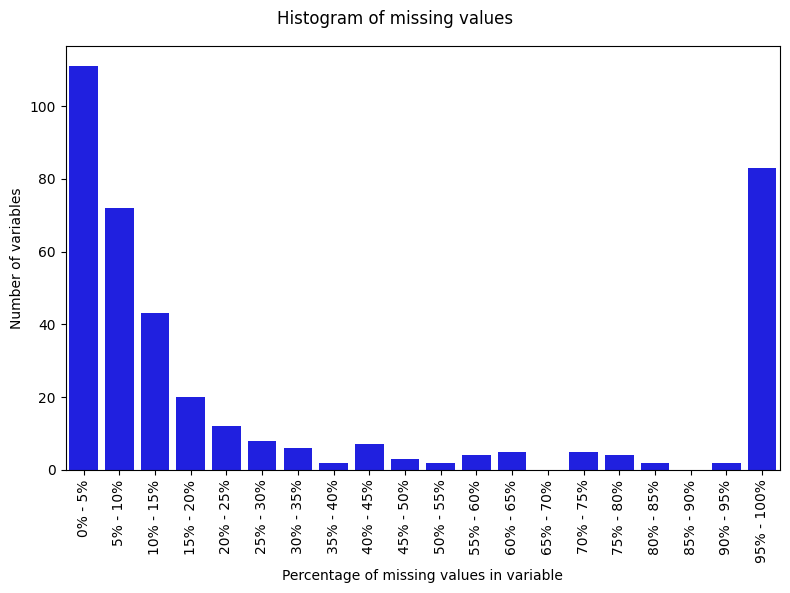

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        dataset.isna().sum() / len(dataset),
        bins=list(np.arange(0, 1.05, .05)),
        labels=[f'{i}% - {i+5}%' for i in range(0, 100, 5)]
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Percentage of missing values in variable')
ax.set_ylabel('Number of variables')

plt.suptitle('Histogram of missing values')

plt.tight_layout();

In [31]:
def preprocessor(temp_dataset, drop_subset, treshold):
    """All initial transformations"""
    # temp_dataset = copy of the original dataset
    # non_num_columns = non-numeric columns
    # div_columns = dividend columns
    # drop_subset = target and auxilliary columns to be removed from X sets
    # treshold = % of observations with missing values

    # Fixing bug resulting from dividing the features
    # In some values dot is replaced by comma and whole column gets wrong data type
    temp_dataset.replace(',', '.', regex=True, inplace=True)
    cat_cols = [
        'dividend_1Y', 'continuous_dividend', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y',
        'pos_net_earnings_3Y', 'pos_net_earnings_2Y', 'pos_net_earnings_1Y',
        'continuous_price_growth'
    ]
    subset = temp_dataset.columns[~temp_dataset.columns.isin([
        'quarter', 'company_code', 'best_price_dynamics_in_q',
        'price_dynamics_y_in_q', 'country', 'industry'
    ])]
    temp_dataset[subset] = temp_dataset[subset].astype(float)
    temp_dataset[cat_cols] = temp_dataset[cat_cols].astype('category')
    temp_dataset = temp_dataset.replace([np.inf, -np.inf], np.nan)

    # Fill NAs in dividend data with 0 (NA here means that dividend most probably wasn't paid)
    # The same for positive net earnings in previous years
    for col in cat_cols:
        temp_dataset[col] = temp_dataset[col].fillna(0)

    # There is a wrong price reported by company FMG in Q4 2018. The company reported price at
    # 0.15 - however, in neighbouring quarters it was 30.93 and 28. Checking this information
    # on another stock exchange website (stooq.pl) confirms that this is an incorrect value
    # - this company was listed on the stock exchange only once in Q4 2018, but with a price of
    # 29, which is a better approximation of the real price.
    idx = temp_dataset.loc[
        np.where(
            (temp_dataset.company_code == 'FMG')
            & (temp_dataset.quarter == '2018/Q4')
        )
    ].index[0]
    temp_dataset.loc[idx, 'price'] = 29
    temp_dataset.loc[idx, 'best_price_dynamics_y'] = (28 - 29) / 29
    temp_dataset.loc[idx, 'price_dynamics_y'] = (9 - 29) / 29

    # Adding new features
    dynamics = {
        'adj_best_price_dynamics_y':
        81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_price_dynamics_y':81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_best_wig_dynamics_y':
        81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_wig_dynamics_y':81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m,
        'final_price_dynamics':pd.Series(
            np.where(
                81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
                .5, 81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m
            )
        ),
        'final_wig_dynamics':pd.Series(
            np.where(
                81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m > .5,
                .5, 81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m
            )
        ),
        'sold_in_q':pd.Series(np.where(
            81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
            temp_dataset.best_price_dynamics_in_q,
            temp_dataset.price_dynamics_y_in_q
        ))
    }
    dynamics = pd.DataFrame(dynamics)

    dynamics['interesting_investment'] = pd.Categorical(
        pd.Series(
            np.where(
                dynamics.final_price_dynamics == .5,
                'Yes', np.where(
                    dynamics.final_price_dynamics >= 0,
                    'Maybe', 'No'
                )
            )
        ),
        categories=['No', 'Maybe', 'Yes'],
        ordered=True
    )

    temp_dataset = pd.concat([temp_dataset, pd.DataFrame(dynamics)], axis=1)

    # Removing variables with more than x% missing values
    temp_dataset.dropna(thresh=len(temp_dataset) * treshold, axis=1, inplace=True)

    # Adding variables describing whether an observation has a missing value
    missing_values = {}
    for col in temp_dataset:
        if temp_dataset[col].isnull().sum() > 0:
            missing_values[col + '_mv'] = np.where(
                temp_dataset[col].isnull(),
                1, 0
            )
    missing_values = pd.DataFrame.from_dict(missing_values, dtype='category')
    temp_dataset = pd.concat([temp_dataset, pd.DataFrame(missing_values)], axis=1)

    # Stratified Split
    for train_index, val_index in StratifiedShuffleSplit(
        n_splits=1, test_size=0.2, random_state=1234
    ).split(temp_dataset, temp_dataset['interesting_investment']):
        train = temp_dataset.loc[train_index]
        val = temp_dataset.loc[val_index]

    # Tuple with processed dataset, X_train, y_train (for regression), y_train (for classification),
    # X_validation, y_validation (for regression), y_validation (for classification)
    return (
        temp_dataset,
        train.drop(drop_subset, axis=1, errors='ignore'),
        train.filter(['final_price_dynamics']),
        train.filter(['interesting_investment']),
        val.drop(drop_subset, axis=1, errors='ignore'),
        val.filter(['final_price_dynamics']),
        val.filter(['interesting_investment'])
    )

In [35]:
def imputer_encoder(train_set, val_set, missing_cols_num):
    """Imputating missing values and encoding variables"""
    # train_set, val_set = training and validation sets
    # one_hot_cols = columns for one-hot encoding

    full_pipeline = ColumnTransformer(
        transformers=[
            ('imputer_num', KNNImputer(), missing_cols_num),
            (
                'oh_encoder',
                OneHotEncoder(handle_unknown='infrequent_if_exist'),
                ['country', 'industry']
            )
        ],
        remainder='passthrough'
    )

    def transformer(temp_dataset, pipe, train):
        """Transforming dataset and changing it into data frame"""

        # Imputing & encoding
        if train:
            final_df = pd.DataFrame(
                pipe.fit_transform(temp_dataset),
                index=temp_dataset.index,
                columns=[col_name.split('__', 1)[1] for col_name in pipe.get_feature_names_out()]
            )
        else:
            final_df = pd.DataFrame(
                pipe.transform(temp_dataset),
                index=temp_dataset.index,
                columns=[col_name.split('__', 1)[1] for col_name in pipe.get_feature_names_out()]
            )

        # Drop unnecessary columns
        final_df.drop(
            ['quarter', 'company_code', 'avg_price_earnings']
            + final_df.filter(regex='rank').columns.tolist(),
            axis=1,
            inplace=True
        )

        # Change numeric features back to float type
        num_cols = [
            col for col in final_df.columns if col not in 
            final_df.filter(regex='country').columns.tolist()
            + final_df.filter(regex='industry').columns.tolist()
            + final_df.filter(regex='_mv').columns.tolist()
            + [
                'dividend_1Y', 'continuous_dividend', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y',
                'pos_net_earnings_3Y', 'pos_net_earnings_2Y', 'pos_net_earnings_1Y',
                'continuous_price_growth'
            ]
        ]
        final_df[num_cols] = final_df[num_cols].apply(pd.to_numeric, downcast='float')

        # Change object features to categorical
        cat_cols = final_df.select_dtypes('object').columns.tolist()
        final_df[cat_cols] = final_df[cat_cols].astype('category')

        return final_df

    # Transforming
    train_set = transformer(train_set, full_pipeline, True)
    val_set = transformer(val_set, full_pipeline, False)

    return train_set, val_set

In [65]:
# Other auxilliary functions

def dataset_stat(x_set, y_reg_set, y_clf_set):
    """Basic statistics of dataset"""
    print('Percentage of features with missing values: '\
        f'{round(100 * x_set.isna().any().sum() / len(x_set.columns), 2)}%')
    print('Percentage of features with more than 50% missing values: '\
        f'{round(100 * (x_set.isna().sum() > .5 * len(x_set)).sum() / len(x_set.columns), 2)}%')
    print('Percentage of missing values in regression target feature: '\
        f'{round(100 * y_reg_set.final_price_dynamics.isna().sum() / len(y_reg_set), 2)}%')
    print('Percentage of missing values in classification target feature: '\
        f'{round(100 * y_clf_set.interesting_investment.isna().sum() / len(y_clf_set), 2)}%')
    print('Percentage of duplicate rows: '\
        f'{round(100 * x_set.duplicated().sum() / len(x_set.columns), 2)}%')

def feature_stat_reg(feature, feature_name, target):
    """Basic statistics of given feature in regression"""
    print(f'Basic statistics of {feature_name}:')
    print(feature.describe().round(2))
    print(f'\nSkewness of {feature_name}: '\
        f'{feature.skew().round(2)}')
    print(f'Kurtosis of {feature_name}: '\
        f'{feature.kurtosis().round(2)}')

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    sns.histplot(
        x=feature,
        color='blue',
        ax=axs[0, 0]
    )

    sns.kdeplot(
        x=feature,
        color='blue',
        ax=axs[0, 1]
    )
    sns.boxplot(
        x=pd.qcut(
            feature,
            20,
            labels=['Below 5th percentile']
            + [f'{i}th - {i+5}th percentile' for i in range(5, 95, 5)]
            + ['Over 95th percentile']
        ),
        y=target,
        ax=axs[1, 0]
    )

    sns.scatterplot(
        x=feature,
        y=target,
        ax=axs[1, 1]
    )

    axs[1, 0].axhline(0, color='black', linewidth=.8)
    axs[1, 1].axhline(0, color='black', linewidth=.8)

    for i in range(2):
        for j in range(2):
            axs[i, j].set_xlabel(feature_name)
            if i == 1:
                axs[i, j].set_ylabel('Final price dynamics')

    axs[1, 0].tick_params(axis='x', labelrotation=90)

    plt.suptitle(feature_name)
    axs[0, 0].set_title('Histogram')
    axs[0, 1].set_title('Density plot')
    axs[1, 0].set_title('Box plot vs final price dynamics')
    axs[1, 1].set_title('Scatter plot vs final price dynamics')

    plt.tight_layout();

def knn_imputer(train_set, val_set, missing_cols_num):
    """Imputating missing values resulted from dividing by 0"""
    # train_set, val_set = training and validation sets

    full_pipeline = ColumnTransformer(
        transformers=[
            ('imputer_num', KNNImputer(), missing_cols_num)
        ],
        remainder='passthrough'
    )

    def transformer(temp_dataset, pipe, train):
        """Transforming dataset and changing it into data frame"""

        # Imputing & encoding
        if train:
            final_df = pd.DataFrame(
                pipe.fit_transform(temp_dataset),
                index=temp_dataset.index,
                columns=[col_name.split('__', 1)[1] for col_name in pipe.get_feature_names_out()]
            )
        else:
            final_df = pd.DataFrame(
                pipe.transform(temp_dataset),
                index=temp_dataset.index,
                columns=[col_name.split('__', 1)[1] for col_name in pipe.get_feature_names_out()]
            )

        # Change numeric features back to float type
        num_cols = [
            col for col in final_df.columns if col not in 
            final_df.filter(regex='country').columns.tolist()
            + final_df.filter(regex='industry').columns.tolist()
            + final_df.filter(regex='_mv').columns.tolist()
            + [
                'dividend_1Y', 'continuous_dividend', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y',
                'pos_net_earnings_3Y', 'pos_net_earnings_2Y', 'pos_net_earnings_1Y',
                'continuous_price_growth'
            ]
        ]
        final_df[num_cols] = final_df[num_cols].apply(pd.to_numeric, downcast='float')

        # Change object features to categorical
        cat_cols = final_df.columns[~final_df.columns.isin(num_cols)]
        final_df[cat_cols] = final_df[cat_cols].astype('category')

        return final_df

    # Transforming
    train_set = transformer(train_set, full_pipeline, True)
    val_set = transformer(val_set, full_pipeline, False)

    return train_set, val_set

def mi_scores(x_train, y_train):
    """MI scores calculation and presenatation"""
    x_train_fact = x_train.copy()
    for col in x_train_fact.select_dtypes('category'):
        x_train_fact[col], _ = x_train_fact[col].factorize()
    discrete_feat = x_train_fact.dtypes == int

    mi_scores = pd.DataFrame(
        mutual_info_regression(
            x_train,
            y_train,
            discrete_features=discrete_feat,
            random_state=1234
        ),
        columns=['MI Regression Scores'],
        index=x_train.columns
    ).sort_values(by='MI Regression Scores', ascending=False)

    print('Number of features with MI score greater than 0: ')
    print(mi_scores[mi_scores['MI Regression Scores']>0].count())
    print('\nFeatures with top MI scores:')
    print(mi_scores['MI Regression Scores'].head(10))

    labels = [
        '\n'.join(wrap(el.replace('_', ' '), 120))
        for el in mi_scores['MI Regression Scores'].head(10).index.tolist()
    ]

    fig, ax = plt.subplots(figsize=(14, 4))

    sns.barplot(
        x=mi_scores['MI Regression Scores'].head(10),
        y=labels,
        color='blue',
        ax=ax
    )

    ax.set_ylabel('Feature')
    plt.suptitle('Mutual Information Scores')

    plt.tight_layout();

    return mi_scores

def xgb_simple(x_train, y_train, x_val, y_val, regression, model_name):
    """Simple calculation of MAE from XGBoost to quickly look at any improvements"""

    def matrix_manipulator(x_set, y_set):
        """Transforming set to DMatrix to keep categorical features"""
        return xgb.DMatrix(x_set, y_set, enable_categorical=True)

    if regression:
        params = xgb.XGBRegressor().get_params()
    else:
        params = xgb.XGBClassifier().get_params()

    train_dm = matrix_manipulator(x_train, y_train)
    val_dm = matrix_manipulator(x_val, y_val)

    model = xgb.train(params, train_dm)

    if regression:
        metrics_dict = {
            'RMSE':round(skm.mean_squared_error(y_val, model.predict(val_dm), squared=False), 4),
            'MAE':round(skm.mean_absolute_error(y_val, model.predict(val_dm)), 4),
            'MAPE':round(skm.mean_absolute_percentage_error(y_val, model.predict(val_dm)), 4)
        }

        print(f'Model: {model_name}')
        for metric, value in metrics_dict.items():
            print(f'{metric}: {value}')

    return model, pd.DataFrame(metrics_dict, index=[model_name])

In [42]:
# Initial preprocessing
dataset_preproc = dataset.copy()
dataset_preproc, X_train, y_reg_train, y_clf_train, X_val, y_reg_val, y_clf_val = preprocessor(
    temp_dataset = dataset_preproc,
    drop_subset = [
        'best_price_dynamics_y', 'price_dynamics_y', 'best_price_dynamics_in_q',
        'price_dynamics_y_in_q', 'inflation_yy_m', 'usd_pln', 'wig', 'wig_6m',
        'best_wig_dynamics_y', 'wig_dynamics_y', 'adj_best_price_dynamics_y',
        'adj_price_dynamics_y', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
        'final_wig_dynamics', 'sold_in_q', 'final_price_dynamics', 'interesting_investment'
    ],
    treshold = 0
)

# Regression model

The basic statistics of the target feature **final_price_dynamics** are similar across the three sets. However, the validation set has a slightly higher minimum value (-0.77 vs -0.8) and higher quartile values (by 0.01 in each case). Similarly, the validation set has a slightly higher skewness and a more platykurtic distribution, which affects the slightly different appearance of the distribution curve of this set (see density plot below).

In [12]:
print('Basic statistics of final_price_dynamics feature:')
pd.concat(
    [dataset_preproc.final_price_dynamics.describe(), y_reg_train.describe(), y_reg_val.describe()],
    axis=1
).set_axis(['Full dataset', 'Training set', 'Validation set'], axis=1).round(2)

Basic statistics of final_price_dynamics feature:


,Full dataset,Training set,Validation set
count,18526.00,14820.00,3706.00
mean,0.01,0.01,0.01
std,0.32,0.32,0.32
min,-0.80,-0.80,-0.77
25%,-0.22,-0.22,-0.23
50%,-0.02,-0.02,-0.01
75%,0.25,0.25,0.26
max,0.50,0.50,0.50


In [13]:
print('Skewness of final_price_dynamics feature in full dataset: '\
    f'{dataset_preproc.final_price_dynamics.skew().round(2)}')
print('Skewness of final_price_dynamics feature in training set: '\
    f'{y_reg_train.final_price_dynamics.skew().round(2)}')
print('Skewness of final_price_dynamics feature in validation set: '\
    f'{y_reg_val.final_price_dynamics.skew().round(2)}')

print('\nKurtosis of final_price_dynamics feature in full dataset: '\
    f'{dataset_preproc.final_price_dynamics.kurtosis().round(2)}')
print('Kurtosis of final_price_dynamics feature in training set: '\
    f'{y_reg_train.final_price_dynamics.kurtosis().round(2)}')
print('Kurtosis of final_price_dynamics feature in validation set: '\
    f'{y_reg_val.final_price_dynamics.kurtosis().round(2)}')

Skewness of final_price_dynamics feature in full dataset: 0.05
Skewness of final_price_dynamics feature in training set: 0.05
Skewness of final_price_dynamics feature in validation set: 0.06

Kurtosis of final_price_dynamics feature in full dataset: -0.87
Kurtosis of final_price_dynamics feature in training set: -0.86
Kurtosis of final_price_dynamics feature in validation set: -0.9


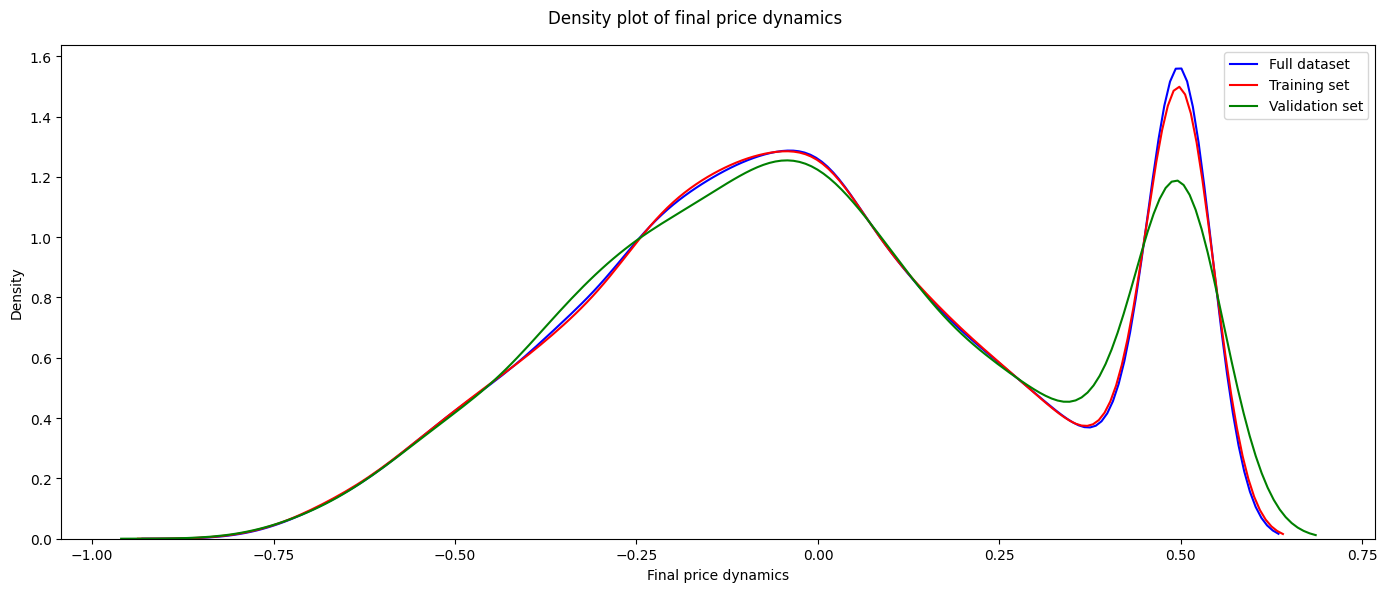

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.kdeplot(
    x=dataset_preproc.final_price_dynamics,
    color='blue',
    label='Full dataset',
    ax=ax
)
sns.kdeplot(
    x=y_reg_train.final_price_dynamics,
    color='red',
    label='Training set',
    ax=ax
)
sns.kdeplot(
    x=y_reg_val.final_price_dynamics,
    color='green',
    label='Validation set',
    ax=ax
)

handles, _ = ax.get_legend_handles_labels()
plt.legend(
    handles = handles,
    labels = ['Full dataset', 'Training set', 'Validation set']
)
ax.set_xlabel('Final price dynamics')
plt.suptitle('Density plot of final price dynamics')

plt.tight_layout();

Extreme gradient boosting (XGBoost) built on the training set (excluding object variables) without imputation of variables and with default parameters will serve as a benchmark for subsequent regression models. The models will be evaluated using root mean squared error (RMSE), mean absolute error (MAE) and mean absolute percentage error (MAPE). As we can see, the RMSE for the benchmark model is 0.2778, the MAE is 0.2279, while MAPE is almost 3.5e12 (sic!).

In [100]:
benchmark_reg, benchmark_df = xgb_simple(
    X_train.drop(['quarter', 'company_code', 'country', 'industry'], axis=1),
    y_reg_train,
    X_val.drop(['quarter', 'company_code', 'country', 'industry'], axis=1),
    y_reg_val,
    True,
    'Benchmark model'
)
reg_model_list = [benchmark_df]

[12:24:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Benchmark model
RMSE: 0.2837
MAE: 0.2328
MAPE: 3626252493990.939


## 1. *Less than 50% missing values* variant

### Dataset exploration

We will first analyse only the variables that contain less than 50% missing values. The full dataset contains 18526 observations and 593 features, while the training and validation sets each contain 616 variables. The difference is due to the fact that there are no target features in these two sets (they are in the **y_reg_train**, **y_clf_train**, **y_reg_val** and **y_clf_val** sets), as well as auxiliary variables that were used to create the target features and that will not be used in the model development. On the other hand, encoding of the features **country** and **industry** has increased the number of variables in the test and validation sets. As intended, there are no missing values in training and validation sets. All datasets have complete information on the target features and there are no duplicate rows.

The MAE and RMSE for the model based on processed training and validation sets are slightly higher than for benchmark model, while MAPE is lower than in the basic model (2.9e12). However, we used a different set of variables in this case - let's see if feature engineering would improve this score.

In [44]:
# Preprocessing - remove variables with more than 50% missing values
dataset_preproc = dataset.copy()
dataset_preproc, X_train, y_reg_train, y_clf_train, X_val, y_reg_val, y_clf_val = preprocessor(
    temp_dataset = dataset_preproc,
    drop_subset = [
        'best_price_dynamics_y', 'price_dynamics_y', 'best_price_dynamics_in_q',
        'price_dynamics_y_in_q', 'inflation_yy_m', 'usd_pln', 'wig', 'wig_6m',
        'best_wig_dynamics_y', 'wig_dynamics_y', 'adj_best_price_dynamics_y',
        'adj_price_dynamics_y', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
        'final_wig_dynamics', 'sold_in_q', 'final_price_dynamics', 'interesting_investment'
    ],
    treshold = .5
)

missing_col_nums = X_train.drop(
    ['quarter', 'company_code', 'country', 'industry'],
    axis=1
).columns.tolist()

# Imputing & encoding
X_train_proc, X_val_proc = imputer_encoder(X_train, X_val, missing_col_nums)

In [45]:
print(f'Size of the full dataset: {dataset_preproc.shape}')
print(f'Size of the training dataset: {X_train_proc.shape}')
print(f'Size of the validation dataset: {X_val_proc.shape}')

Size of the full dataset: (18526, 593)
Size of the training dataset: (14820, 616)
Size of the validation dataset: (3706, 616)


In [46]:
print('Full dataset:')
dataset_stat(dataset_preproc, dataset_preproc, dataset_preproc)
print('\nTraining dataset:')
dataset_stat(X_train_proc, y_reg_train, y_clf_train)
print('\nValidation dataset:')
dataset_stat(X_train_proc, y_reg_val, y_clf_val)

Full dataset:
Percentage of features with missing values: 46.71%
Percentage of features with more than 50% missing values: 0.0%
Percentage of missing values in regression target feature: 0.0%
Percentage of missing values in classification target feature: 0.0%
Percentage of duplicate rows: 0.0%

Training dataset:
Percentage of features with missing values: 0.0%
Percentage of features with more than 50% missing values: 0.0%
Percentage of missing values in regression target feature: 0.0%
Percentage of missing values in classification target feature: 0.0%
Percentage of duplicate rows: 0.0%

Validation dataset:
Percentage of features with missing values: 0.0%
Percentage of features with more than 50% missing values: 0.0%
Percentage of missing values in regression target feature: 0.0%
Percentage of missing values in classification target feature: 0.0%
Percentage of duplicate rows: 0.0%


In [101]:
xgb_reg_base_50, xgb_reg_base_50_df = xgb_simple(
    X_train_proc, y_reg_train, X_val_proc, y_reg_val, True, 'Less than 50% MV (base)'
)
reg_model_list.append(xgb_reg_base_50_df)
reg_model_metrics = pd.concat(reg_model_list)
reg_model_metrics

[12:24:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (base)
RMSE: 0.2931
MAE: 0.2403
MAPE: 2860953680303.584


,RMSE,MAE,MAPE
Benchmark model,0.2837,0.2328,3.626252e+12
Less than 50% MV (base),0.2931,0.2403,2.860954e+12


### Feature engineering for regression

The datasets analysed have a large number of variables  - we will first check which variables will be most useful in the model using the mutual information index (MI). Of the 616 variables in the test set, 546 scored higher than 0 and five features scored higher than 0.05 (**number_of_shares**, **core_capital**, **price**, **capitalization** and **supplementary_capital**). Given that the minimum MI score is 0, these results are not staggering.

Using only variables whose MI score is greater than zero, the model achieves slightly worse RMSE and MAE values, however has quite significantly lower MAPE (2.6e12). In contrast, restricting to variables whose MI score is greater than 0.05 slightly worsens the RMSE and MAE, but also lowers the MAPE to 2.1e12.

Number of features with MI score greater than 0: 
MI Regression Scores    546
dtype: int64

Features with top MI scores:
number_of_shares                            0.064400
core_capital                                0.062025
price                                       0.054708
supplementary_capital                       0.053511
capitalization                              0.052648
capitalization_usd                          0.044135
sum_earnings_share_1Y_earnings_per_share    0.042619
avg_earnings_share_1Y                       0.041349
sales_revenues_1Y_usd                       0.040445
sum_earnings_share_1Y                       0.040391
Name: MI Regression Scores, dtype: float64


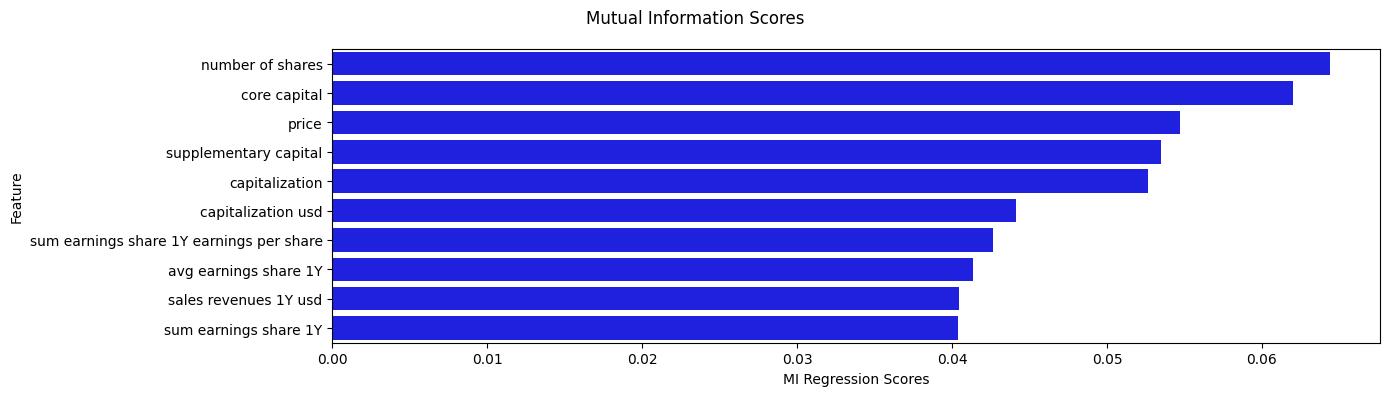

In [48]:
mi_reg_base_50 = mi_scores(X_train_proc, y_reg_train.final_price_dynamics)

In [102]:
positive_mi = mi_reg_base_50[mi_reg_base_50['MI Regression Scores']>0].index.tolist()
xgb_reg_base_50_pos_mi, xgb_reg_base_50_pos_mi_df = xgb_simple(
    X_train_proc.filter(positive_mi, axis=1),
    y_reg_train,
    X_val_proc.filter(positive_mi, axis=1),
    y_reg_val,
    True, 'Less than 50% MV (base, positive MI)'
)

high_mi = mi_reg_base_50[mi_reg_base_50['MI Regression Scores']>.05].index.tolist()
xgb_reg_base_50_high_mi, xgb_reg_base_50_high_mi_df = xgb_simple(
    X_train_proc.filter(high_mi, axis=1),
    y_reg_train,
    X_val_proc.filter(high_mi, axis=1),
    y_reg_val,
    True, 'Less than 50% MV (base, high MI)'
)

reg_model_list.append(xgb_reg_base_50_pos_mi_df)
reg_model_list.append(xgb_reg_base_50_high_mi_df)
reg_model_metrics = pd.concat(reg_model_list)
reg_model_metrics

[12:24:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (base, positive MI)
RMSE: 0.2958
MAE: 0.2426
MAPE: 2592189256360.2803
[12:24:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (base, high MI)
RMSE: 0.3084
MAE: 0.2557
MAPE: 2082542276041.2175


,RMSE,MAE,MAPE
Benchmark model,0.2837,0.2328,3.626252e+12
Less than 50% MV (base),0.2931,0.2403,2.860954e+12
"Less than 50% MV (base, positive MI)",0.2958,0.2426,2.592189e+12
"Less than 50% MV (base, high MI)",0.3084,0.2557,2.082542e+12


For a good start, we can use logarithm and exponential functions on highly skew features. There are 278 numeric variables in the training set, 277 of which have skewness below -1 or above 1. For simplicity, we will transform all numeric features. In this way, we obtained eight variables whose MI score is higher than 0.05 (**log_number_of_shares**, **log_core_capital**, **exp_supplementary_capital**, **exp_number_of_shares**, **log_supplementary_capital**, **exp_core_capital**, **exp_price**, **exp_capitalization**). As can be seen, the transformations that achieved the highest MI scores involved five variables that also had MI scores greater than 0.05 in their base form. Adding all new variables to the model did not improve its performance, while restricting to variables with an MI score above 0.05 still yielded worse values for the RMSE, MAE and MAPE indices than for the model in the *Less than 50% MV (base, high MI)* variant.

*To be precise: many variables have non-additive values. To enable them to be logarithmised, the variables have been increased by the absolute value of their minimum and then by 1. For exponential function all variables have been divided by their maximum order of magnitude to avoid overflow. We have used both functions on all numerical variables regardless of the sign their skewness, as it may be different for the same variable in training and validatation sets.* 

In [51]:
numeric = ['float64', 'float32']
print('Number of numerical features: '\
    f'{X_train_proc.select_dtypes(numeric).shape[1]}')
print('Number of numerical features with skewness lower than -1 or greater than 1: '\
    f'{sum(abs(X_train_proc.skew(numeric_only=True)) > 1)}')
print(f'Number of highly right-skewed features: {sum(X_train_proc.skew(numeric_only=True) > 1)}')
print(f'Number of highly left-skewed features: {sum(X_train_proc.skew(numeric_only=True) < -1)}')

Number of numerical features: 278
Number of numerical features with skewness lower than -1 or greater than 1: 277
Number of highly right-skewed features: 206
Number of highly left-skewed features: 71


In [90]:
def log_exp_features(source_set):
    """Function adding log feature for variables with high skewness"""
    numeric_cols = source_set.select_dtypes(['float64', 'float32']).columns.to_list()
    log_exp_dict = {}

    for col in numeric_cols:
        log_exp_dict['log_' + col] = np.log(source_set[col].add(abs(min(source_set[col])) + 1))
        log_exp_dict['exp_' + col] = np.exp(
            (source_set[col] / 10 ** int(math.log10(max(
                abs(source_set[col].min()),
                abs(source_set[col].max())
            )))).astype(float)
        )

    return pd.concat([source_set, pd.DataFrame(log_exp_dict)], axis=1)

X_train_proc_log_exp = log_exp_features(X_train_proc)
X_val_proc_log_exp = log_exp_features(X_val_proc)

Number of features with MI score greater than 0: 
MI Regression Scores    1076
dtype: int64

Features with top MI scores:
log_number_of_shares         0.087389
log_core_capital             0.071859
exp_supplementary_capital    0.064592
exp_number_of_shares         0.064072
core_capital                 0.063899
number_of_shares             0.062278
log_supplementary_capital    0.060931
exp_core_capital             0.055426
exp_price                    0.052917
supplementary_capital        0.052469
Name: MI Regression Scores, dtype: float64


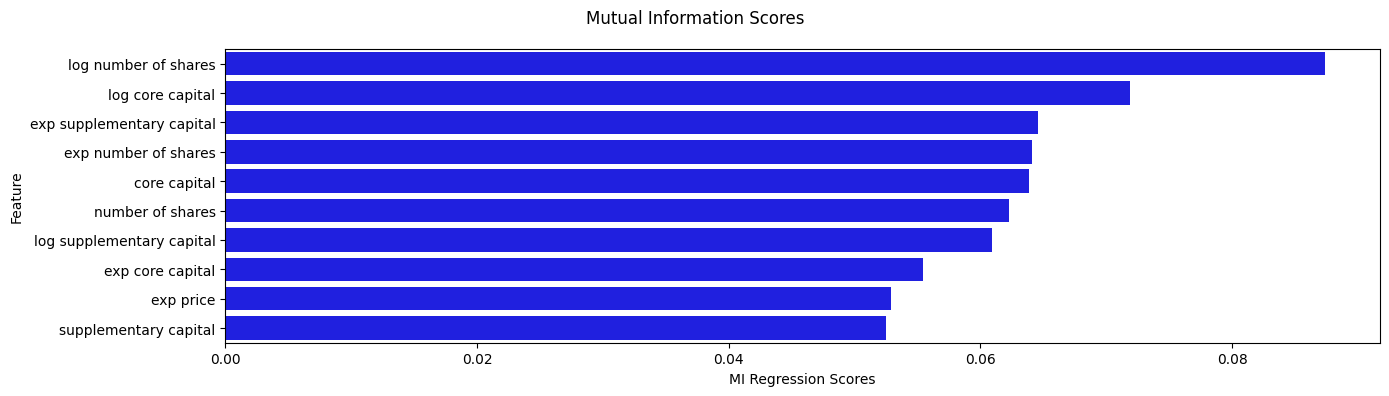

In [53]:
mi_reg_log_exp_50 = mi_scores(X_train_proc_log_exp, y_reg_train.final_price_dynamics)

In [103]:
xgb_reg_log_exp_50, xgb_reg_log_exp_50_df = xgb_simple(
    X_train_proc_log_exp, y_reg_train, X_val_proc_log_exp, y_reg_val,
    True, 'Less than 50% MV (log_exp)'
)

positive_mi = mi_reg_log_exp_50[mi_reg_log_exp_50['MI Regression Scores']>0].index.tolist()
xgb_reg_log_exp_50_pos_mi, xgb_reg_log_exp_50_pos_mi_df = xgb_simple(
    X_train_proc_log_exp.filter(positive_mi, axis=1),
    y_reg_train,
    X_val_proc_log_exp.filter(positive_mi, axis=1),
    y_reg_val,
    True, 'Less than 50% MV (log_exp, positive MI)'
)

high_mi = mi_reg_log_exp_50[mi_reg_log_exp_50['MI Regression Scores']>.05].index.tolist()
xgb_reg_log_exp_50_high_mi, xgb_reg_log_exp_50_high_mi_df = xgb_simple(
    X_train_proc_log_exp.filter(high_mi, axis=1),
    y_reg_train,
    X_val_proc_log_exp.filter(high_mi, axis=1),
    y_reg_val,
    True, 'Less than 50% MV (log_exp, high MI)'
)

reg_model_list.append(xgb_reg_log_exp_50_df)
reg_model_list.append(xgb_reg_log_exp_50_pos_mi_df)
reg_model_list.append(xgb_reg_log_exp_50_high_mi_df)
reg_model_metrics = pd.concat(reg_model_list)
reg_model_metrics

[12:24:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (log_exp)
RMSE: 0.2931
MAE: 0.2403
MAPE: 2860953680303.584
[12:25:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (log_exp, positive MI)
RMSE: 0.3156
MAE: 0.2615
MAPE: 3417181162661.8306
[12:25:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (log_exp, high MI)
RMSE: 0.3229
MAE: 0.2644
MAPE: 2548994502102.665


,RMSE,MAE,MAPE
Benchmark model,0.2837,0.2328,3.626252e+12
Less than 50% MV (base),0.2931,0.2403,2.860954e+12
"Less than 50% MV (base, positive MI)",0.2958,0.2426,2.592189e+12
"Less than 50% MV (base, high MI)",0.3084,0.2557,2.082542e+12
Less than 50% MV (log_exp),0.2931,0.2403,2.860954e+12
"Less than 50% MV (log_exp, positive MI)",0.3156,0.2615,3.417181e+12
"Less than 50% MV (log_exp, high MI)",0.3229,0.2644,2.548995e+12


From the analysis of the gurus' strategies, we can conclude that the ratios used often referred to the share price (e.g. price to earnings ratio) and sometimes also to the number of shares (e.g. price to average earnings per share). We will try to use this knowledge to create new ratios:
- dividing the price by another indicator (*price_to_ratio*),
- dividing an indicator by the number of shares (*ratio_per_share*).

This resulted in several more variables with MI scores above 0.05: price_to_capitalization, core_capital_per_share, supplementary_capital_per_share, capitalization_per_share. However, these are still based on the top five variables from the core dataset. The results achieved by the model including the new variables were very close to the benchmark model for RMSE and MAE, and better in terms of MAPE (2.6e12 vs. 3.6e12). While restricting to variables with higher MI scores produced slightly worse RMSE and MAE, they lowered MAPE to 2.14e12.

In [96]:
def price_share_features(source_set):
    """Function creating new variables using price and number of shares"""

    price_cols = source_set.filter(regex='price').columns.tolist()
    share_cols = source_set.filter(regex='share').columns.tolist()
    cat_cols = source_set.select_dtypes('category').columns.tolist()

    temp_set = {}

    for col in source_set:
        if col not in price_cols + cat_cols:
            temp_set['price_to_' + col] = source_set.price / source_set[col]
        if col not in share_cols + cat_cols + ['ebit', 'sales_revenues']:
            temp_set[col + '_per_share'] = source_set[col] / source_set.number_of_shares

    temp_set = pd.concat([source_set, pd.DataFrame(temp_set)], axis=1)

    # Replace inf with nan
    temp_set = temp_set.replace([np.inf, -np.inf], np.nan)

    return temp_set

X_train_proc_ps_ratio = price_share_features(X_train_proc)
X_val_proc_ps_ratio = price_share_features(X_val_proc)

In [97]:
# Some variables have zeros, so using them as divisor causes NAs
# KNNImputer will fill the gaps
missing_col_nums = X_train_proc_ps_ratio.drop(
    X_train_proc_ps_ratio.select_dtypes('category').columns.tolist(),
    axis=1
).columns.tolist()

X_train_proc_ps_ratio, X_val_proc_ps_ratio = knn_imputer(
    X_train_proc_ps_ratio,
    X_val_proc_ps_ratio,
    missing_col_nums
)

Number of features with MI score greater than 0: 
MI Regression Scores    1005
dtype: int64

Features with top MI scores:
price_to_capitalization            0.071339
core_capital                       0.063621
number_of_shares                   0.063201
core_capital_per_share             0.062240
supplementary_capital_per_share    0.058590
capitalization_per_share           0.054430
price                              0.052739
supplementary_capital              0.052284
capitalization                     0.052188
capitalization_usd                 0.044172
Name: MI Regression Scores, dtype: float64


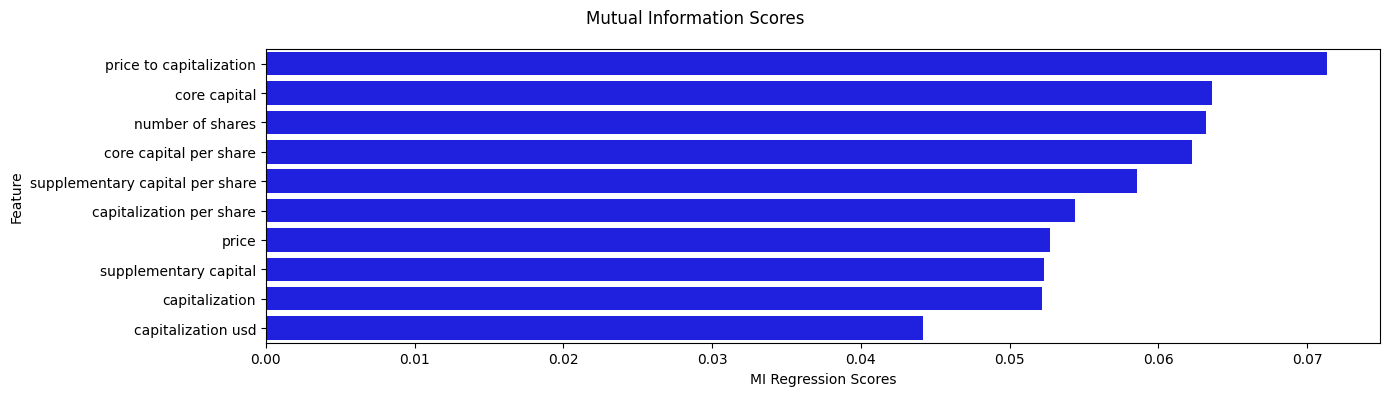

In [98]:
mi_reg_ps_ratio_50 = mi_scores(X_train_proc_ps_ratio, y_reg_train.final_price_dynamics)

In [104]:
xgb_reg_ps_ratio_50, xgb_reg_ps_ratio_50_df = xgb_simple(
    X_train_proc_ps_ratio, y_reg_train, X_val_proc_ps_ratio, y_reg_val,
    True, 'Less than 50% MV (price & share ratios)'
)

positive_mi = mi_reg_ps_ratio_50[mi_reg_ps_ratio_50['MI Regression Scores']>0].index.tolist()
xgb_reg_ps_ratio_50_pos_mi, xgb_reg_ps_ratio_50_pos_mi_df = xgb_simple(
    X_train_proc_ps_ratio.filter(positive_mi, axis=1),
    y_reg_train,
    X_val_proc_ps_ratio.filter(positive_mi, axis=1),
    y_reg_val,
    True, 'Less than 50% MV (price & share ratios, positive MI)'
)

high_mi = mi_reg_ps_ratio_50[mi_reg_ps_ratio_50['MI Regression Scores']>.05].index.tolist()
xgb_reg_ps_ratio_50_high_mi, xgb_reg_ps_ratio_50_high_mi_df = xgb_simple(
    X_train_proc_ps_ratio.filter(high_mi, axis=1),
    y_reg_train,
    X_val_proc_ps_ratio.filter(high_mi, axis=1),
    y_reg_val,
    True, 'Less than 50% MV (price & share ratios, high MI)'
)

reg_model_list.append(xgb_reg_ps_ratio_50_df)
reg_model_list.append(xgb_reg_ps_ratio_50_pos_mi_df)
reg_model_list.append(xgb_reg_ps_ratio_50_high_mi_df)
reg_model_metrics = pd.concat(reg_model_list)
reg_model_metrics

[12:25:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (price & share ratios)
RMSE: 0.2899
MAE: 0.2385
MAPE: 2622580410434.8867
[12:25:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (price & share ratios, positive MI)
RMSE: 0.2924
MAE: 0.241
MAPE: 3142181306272.46
[12:25:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (price & share ratios, high MI)
RMSE: 0.3076
MAE: 0.2553
MAPE: 2144

,RMSE,MAE,MAPE
Benchmark model,0.2837,0.2328,3.626252e+12
Less than 50% MV (base),0.2931,0.2403,2.860954e+12
"Less than 50% MV (base, positive MI)",0.2958,0.2426,2.592189e+12
"Less than 50% MV (base, high MI)",0.3084,0.2557,2.082542e+12
Less than 50% MV (log_exp),0.2931,0.2403,2.860954e+12
"Less than 50% MV (log_exp, positive MI)",0.3156,0.2615,3.417181e+12
"Less than 50% MV (log_exp, high MI)",0.3229,0.2644,2.548995e+12
Less than 50% MV (price & share ratios),0.2899,0.2385,2.622580e+12
"Less than 50% MV (price & share ratios, positive MI)",0.2924,0.2410,3.142181e+12
"Less than 50% MV (price & share ratios, high MI)",0.3076,0.2553,2.144387e+12


A common feature of the guru's strategy is that some indicator was usually selected and a certain threshold was set to determine potentially profitable companies. For example, Zweig's modified strategy was to select companies that, among other things, had a P/E ratio below 12. We will implement this idea by dividing each numerical variable into 20 intervals with an equal number of observations.

In [183]:
X_train_proc_all_trans_50 = pd.concat(
    [
        X_train_proc,
        X_train_proc_log_exp.drop(X_train_proc.columns.to_list(), axis=1),
        X_train_proc_ps_ratio.drop(X_train_proc.columns.to_list(), axis=1)
    ],
    axis=1
)
X_val_proc_all_trans_50 = pd.concat(
    [
        X_val_proc,
        X_val_proc_log_exp.drop(X_val_proc.columns.to_list(), axis=1),
        X_val_proc_ps_ratio.drop(X_val_proc.columns.to_list(), axis=1)
    ],
    axis=1
)

Number of features with MI score greater than 0: 
MI Regression Scores    1553
dtype: int64

Features with top MI scores:
log_number_of_shares               0.087585
log_core_capital                   0.071953
price_to_capitalization            0.070318
core_capital_per_share             0.067366
number_of_shares                   0.064600
log_supplementary_capital          0.063191
exp_supplementary_capital          0.063130
exp_number_of_shares               0.062562
core_capital                       0.060956
supplementary_capital_per_share    0.059630
Name: MI Regression Scores, dtype: float64


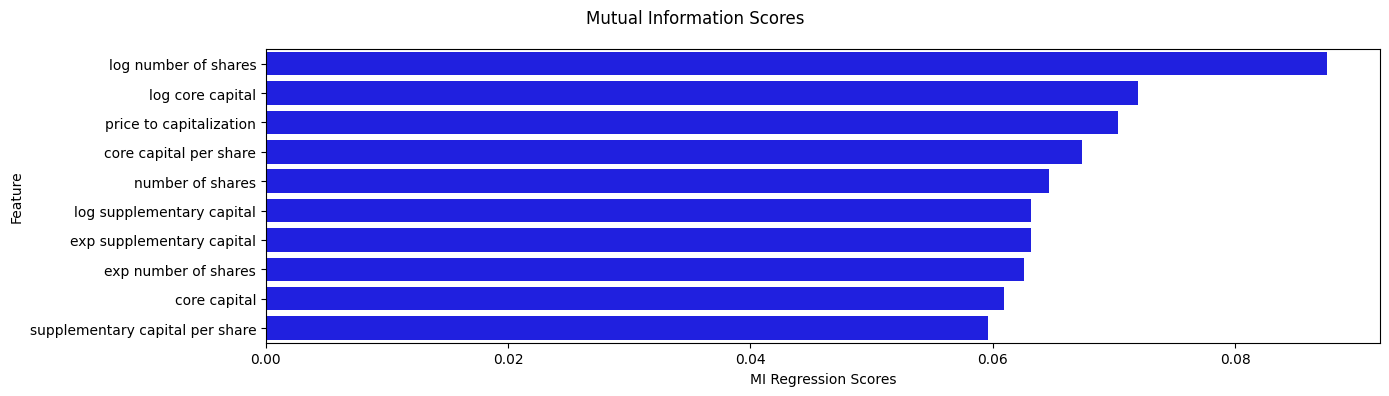

In [182]:
mi_reg_all_trans_50 = mi_scores(X_train_proc_all_trans_50, y_reg_train.final_price_dynamics)

In [184]:
xgb_reg_all_trans_50, xgb_reg_all_trans_50_df = xgb_simple(
    X_train_proc_all_trans_50, y_reg_train, X_val_proc_all_trans_50, y_reg_val,
    True, 'Less than 50% MV (all transformations)'
)

positive_mi = mi_reg_all_trans_50[mi_reg_all_trans_50['MI Regression Scores']>0].index.tolist()
xgb_reg_all_trans_50_pos_mi, xgb_reg_all_trans_50_pos_mi_df = xgb_simple(
    X_train_proc_all_trans_50.filter(positive_mi, axis=1),
    y_reg_train,
    X_val_proc_all_trans_50.filter(positive_mi, axis=1),
    y_reg_val,
    True, 'Less than 50% MV (all transformations, positive MI)'
)

high_mi = mi_reg_all_trans_50[mi_reg_all_trans_50['MI Regression Scores']>.05].index.tolist()
xgb_reg_all_trans_50_high_mi, xgb_reg_all_trans_50_high_mi_df = xgb_simple(
    X_train_proc_all_trans_50.filter(high_mi, axis=1),
    y_reg_train,
    X_val_proc_all_trans_50.filter(high_mi, axis=1),
    y_reg_val,
    True, 'Less than 50% MV (all transformations, high MI)'
)

reg_model_list.append(xgb_reg_all_trans_50_df)
reg_model_list.append(xgb_reg_all_trans_50_pos_mi_df)
reg_model_list.append(xgb_reg_all_trans_50_high_mi_df)
reg_model_metrics = pd.concat(reg_model_list)
reg_model_metrics

[14:41:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (all transformations)
RMSE: 0.2899
MAE: 0.2385
MAPE: 2622580410434.8867
[14:41:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (all transformations, positive MI)
RMSE: 0.299
MAE: 0.2456
MAPE: 3460860301594.5117
[14:41:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing", "n_estimators" } are not used.

Model: Less than 50% MV (all transformations, high MI)
RMSE: 0.3199
MAE: 0.2629
MAPE: 29197

,RMSE,MAE,MAPE
Benchmark model,0.2837,0.2328,3.626252e+12
Less than 50% MV (base),0.2931,0.2403,2.860954e+12
"Less than 50% MV (base, positive MI)",0.2958,0.2426,2.592189e+12
"Less than 50% MV (base, high MI)",0.3084,0.2557,2.082542e+12
Less than 50% MV (log_exp),0.2931,0.2403,2.860954e+12
"Less than 50% MV (log_exp, positive MI)",0.3156,0.2615,3.417181e+12
"Less than 50% MV (log_exp, high MI)",0.3229,0.2644,2.548995e+12
Less than 50% MV (price & share ratios),0.2899,0.2385,2.622580e+12
"Less than 50% MV (price & share ratios, positive MI)",0.2924,0.2410,3.142181e+12
"Less than 50% MV (price & share ratios, high MI)",0.3076,0.2553,2.144387e+12


Basic statistics of P/E ratio:
count    1.482000e+04
mean     2.398336e+09
std      1.325683e+10
min      2.371200e+04
25%      4.819041e+07
50%      1.462027e+08
75%      6.024227e+08
max      3.644380e+11
Name: capitalization, dtype: float64

Skewness of P/E ratio: 15.97
Kurtosis of P/E ratio: 335.99


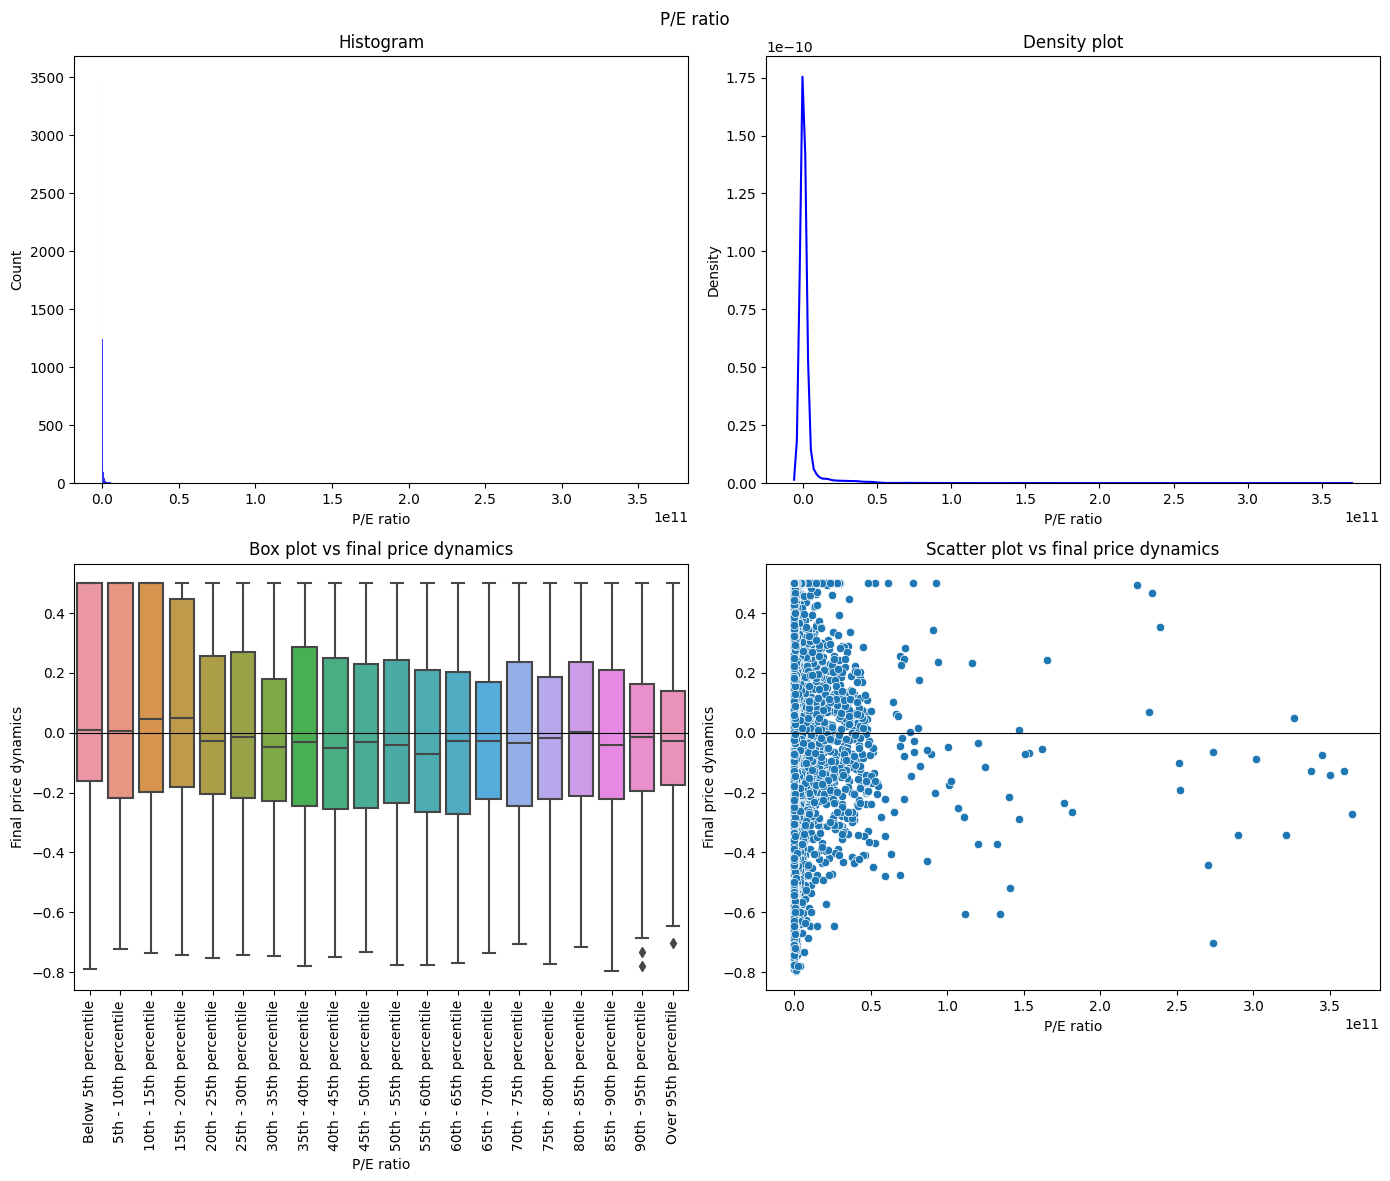

In [66]:
feature_stat_reg(X_train_proc.capitalization, 'P/E ratio', y_reg_train.final_price_dynamics)

# Classification model

In [60]:
print('Values of interesting_investment feature in full dataset:\n'\
    f'{dataset_preproc.interesting_investment.value_counts()}')
print('\nValues of interesting_investment feature in training dataset:\n'\
    f'{y_clf_train.interesting_investment.value_counts()}')
print('\nValues of interesting_investment feature in validation dataset:\n'\
    f'{y_clf_val.interesting_investment.value_counts()}')

Values of interesting_investment feature in full dataset:
No       9613
Maybe    5903
Yes      3010
Name: interesting_investment, dtype: int64

Values of interesting_investment feature in training dataset:
No       7690
Maybe    4722
Yes      2408
Name: interesting_investment, dtype: int64

Values of interesting_investment feature in validation dataset:
No       1923
Maybe    1181
Yes       602
Name: interesting_investment, dtype: int64


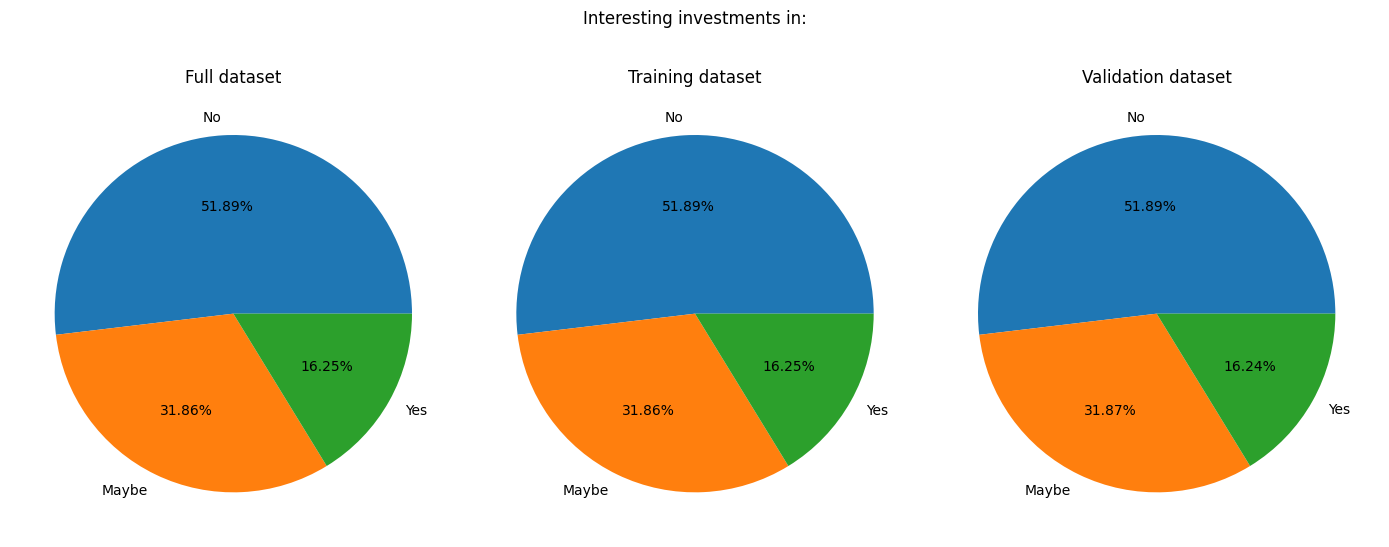

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

axs[0].pie(
    dataset_preproc.interesting_investment.value_counts(normalize=True),
    labels=['No', 'Maybe', 'Yes'],
    autopct='%.2f%%'
)

axs[1].pie(
    y_clf_train.interesting_investment.value_counts(normalize=True),
    labels=['No', 'Maybe', 'Yes'],
    autopct='%.2f%%'
)

axs[2].pie(
    y_clf_val.interesting_investment.value_counts(normalize=True),
    labels=['No', 'Maybe', 'Yes'],
    autopct='%.2f%%'
)

plt.suptitle('Interesting investments in:')
axs[0].set_title('Full dataset')
axs[1].set_title('Training dataset')
axs[2].set_title('Validation dataset')

plt.tight_layout();